In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import statsmodels.api as sm
import datetime

from scipy import stats
from dateutil.relativedelta import relativedelta

import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

# Прогнозирование уровня средней заработной платы в России

## Визуальный анализ ряда

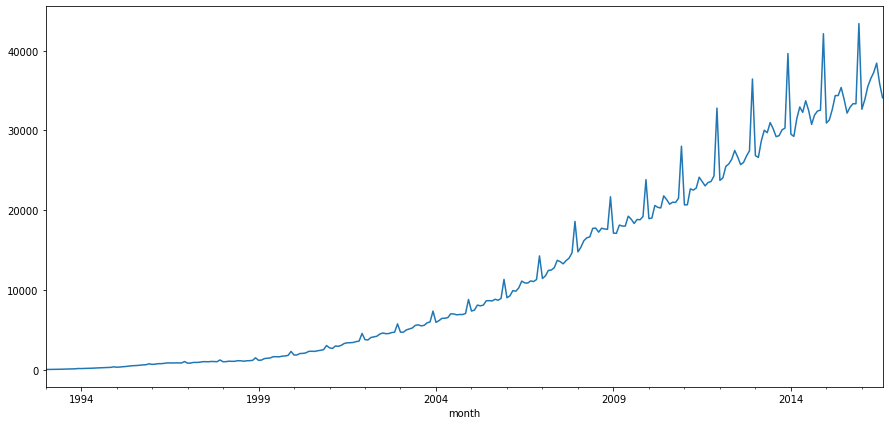

In [125]:
wage = pd.read_csv('WAG_C_M.csv', sep=';', index_col='month', parse_dates=['month'], dayfirst=True)
wage.rename(columns={'WAG_C_M': 'wage'}, inplace=True)
plt.figure(figsize=(15, 7))
wage['wage'].plot()
plt.show()

На графике отчетливо видны тренд и сезонность. Ряд нельзя считать стационарным.

Критерий Дики-Фуллера: p=0.9918495954854734


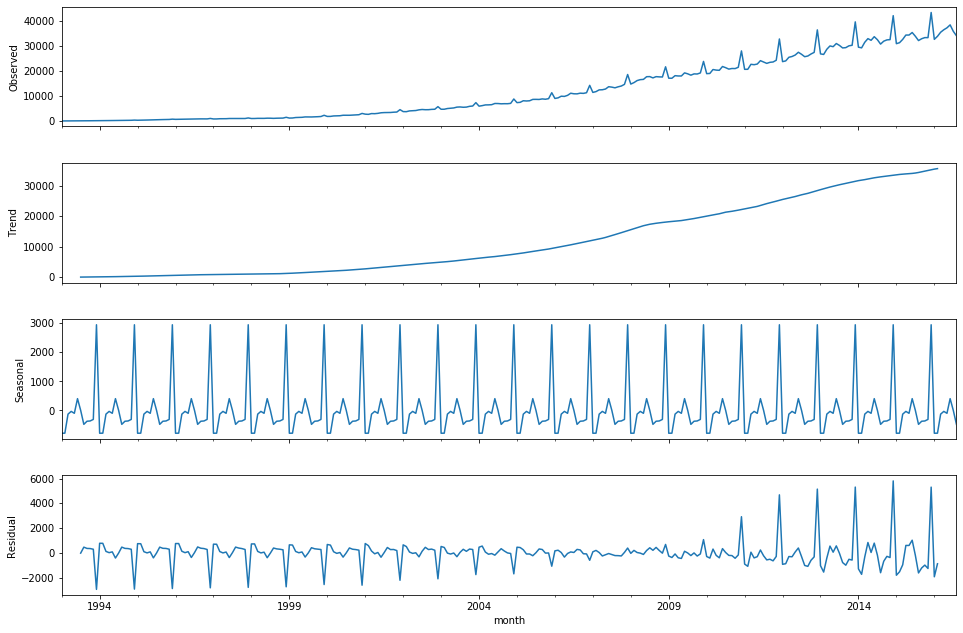

In [126]:
fig = sm.tsa.seasonal_decompose(wage['wage']).plot()
fig.set_size_inches(15, 10)
print('Критерий Дики-Фуллера: p={}'.format(sm.tsa.stattools.adfuller(wage['wage'])[1]))

На основании большого достигаемого уровня значимости критерия Дики-Фуллера, гипотеза о нестационарности временного ряда не отвергается.

## Стабилизация дисперсии с помощью преобразования Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


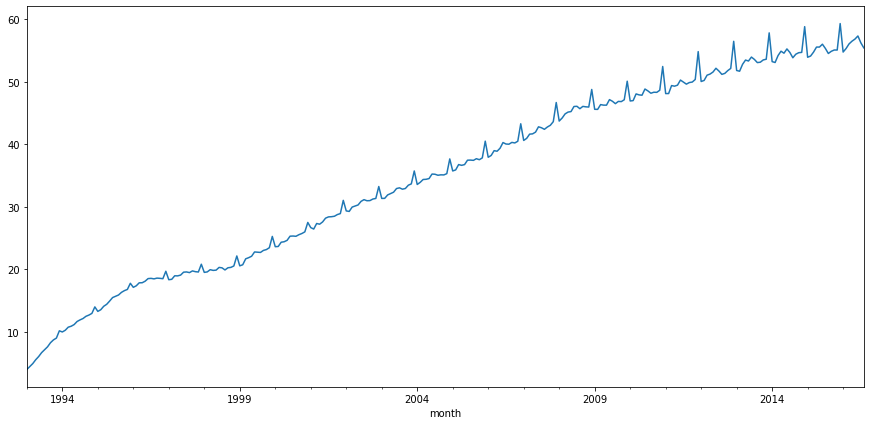

In [127]:
wage['wage_box'], lmbda = stats.boxcox(wage['wage'])
plt.figure(figsize=(15,7))
wage['wage_box'].plot()
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage['wage_box'])[1])

## Выбор порядка дифференцирования

Критерий Дики-Фуллера по-прежнему не отвергает гипотезу о нестационарности ряда. Да и по графику видно, что присутствуют тренд и сезонность. Сделаю сезонное дифференцирование и STL-декомпозицию.

Критерий Дики-Фуллера: p=0.014697133494791847


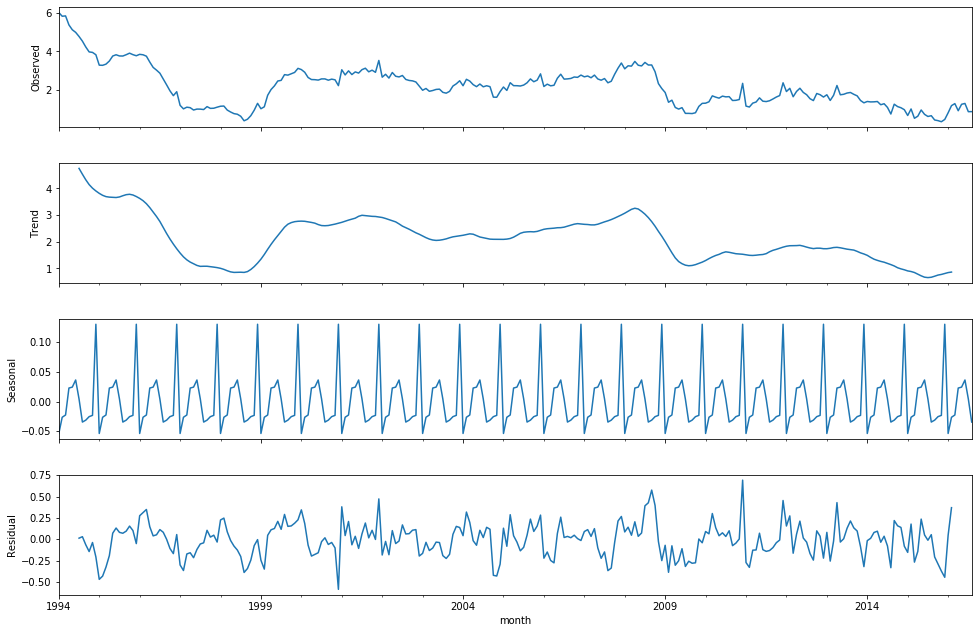

In [128]:
wage['wage_box_1s_diff'] = wage['wage_box'] - wage['wage_box'].shift(12)
fig = sm.tsa.seasonal_decompose(wage['wage_box_1s_diff'][12:]).plot()
fig.set_size_inches(15, 10)
print('Критерий Дики-Фуллера: p={}'.format(sm.tsa.stattools.adfuller(wage['wage_box_1s_diff'][12:])[1]))

По графикам видно, что тренд смещен относительно нуля. Применю обычное дифференцирование.

Критерий Дики-Фуллера: p=5.203603715821878e-08


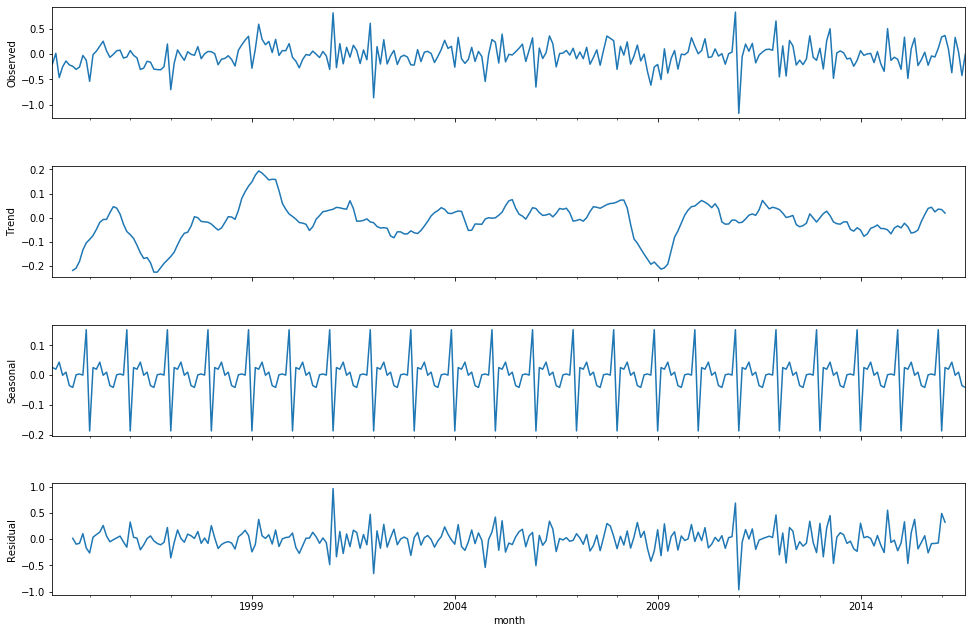

In [129]:
wage['wage_box_1s_1d_diff'] = wage['wage_box_1s_diff'] - wage['wage_box_1s_diff'].shift(1)
fig = sm.tsa.seasonal_decompose(wage['wage_box_1s_1d_diff'][13:]).plot()
fig.set_size_inches(15, 10)
print('Критерий Дики-Фуллера: p={}'.format(sm.tsa.stattools.adfuller(wage['wage_box_1s_1d_diff'][13:])[1]))

Выглядит не плохо. И гипотеза о нестационарности ряда отвергается по критерию Дики-Фуллера.

## Выбор начальных приближений для $p$, $q$, $P$, $Q$

Построю ACF и PACF графики.

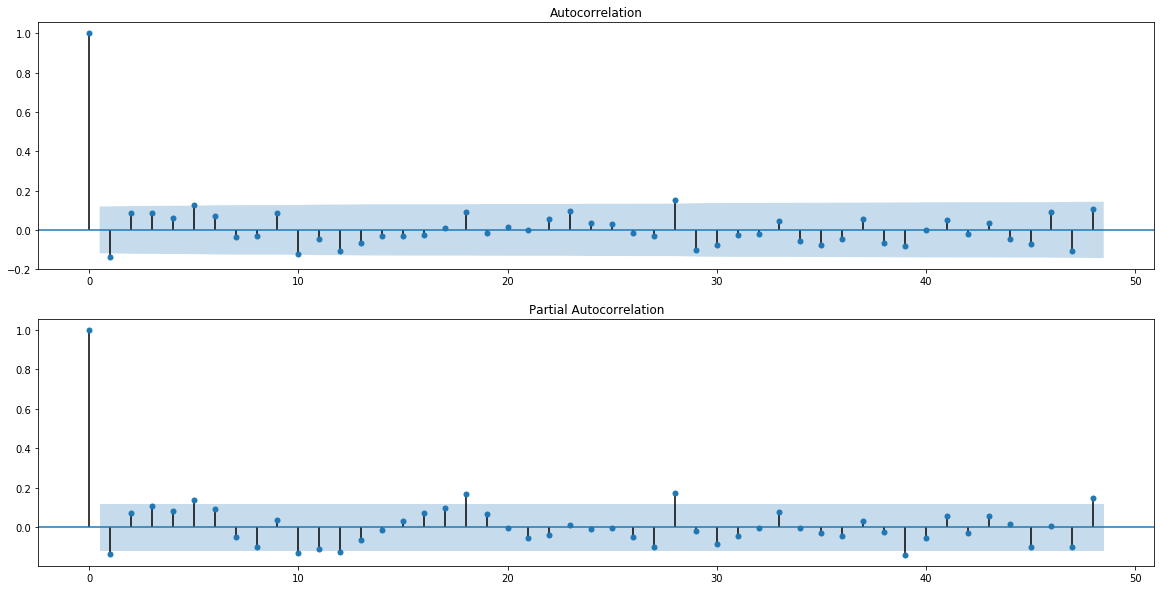

In [130]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage['wage_box_1s_1d_diff'][13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage['wage_box_1s_1d_diff'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: $Q=1$, $q=5$, $P=4$, $p=10$

In [131]:
ps = range(0, 11)
d = 1
qs = range(0, 6)
Ps = range(0, 5)
D = 1
Qs = range(0, 2)

In [132]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

660

## Обучение и сравнение моделей-кандидатов, выбор победителя

In [89]:
%%time

results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(wage['wage_box'],
                                          order=(param[0], d, param[1]),
                                          seasonal_order=(param[2], D, param[3], 12),
                                          initialization='approximate_diffuse').fit(disp=-1)
    except ValueError:
        print('Wrong parameters:', param)
        continue
    if model.aic < best_aic:
        best_model = model
        best_aic = model.aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

CPU times: user 2h 23min 58s, sys: 1min 43s, total: 2h 25min 41s
Wall time: 1h 19min 41s


In [133]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
170  (2, 5, 0, 0) -11.288655
110  (1, 5, 0, 0)  -9.511723
230  (3, 5, 0, 0)  -8.699061
270  (4, 3, 0, 0)  -6.831590
160  (2, 4, 0, 0)  -6.115581


Лучшая модель:

In [134]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(2, 1, 5)x(0, 1, 0, 12)   Log Likelihood                  13.644
Date:                            Thu, 04 Jun 2020   AIC                            -11.289
Time:                                    19:55:32   BIC                             17.528
Sample:                                01-01-1993   HQIC                             0.282
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6991      0.211      3.314      0.001       0.286       1.112
ar.L2         -0.1375      0.081   

## Анализ остатков построенной модели

Критерий Стьюдента: p=0.330396
Критерий Дики-Фуллера: p=0.000000


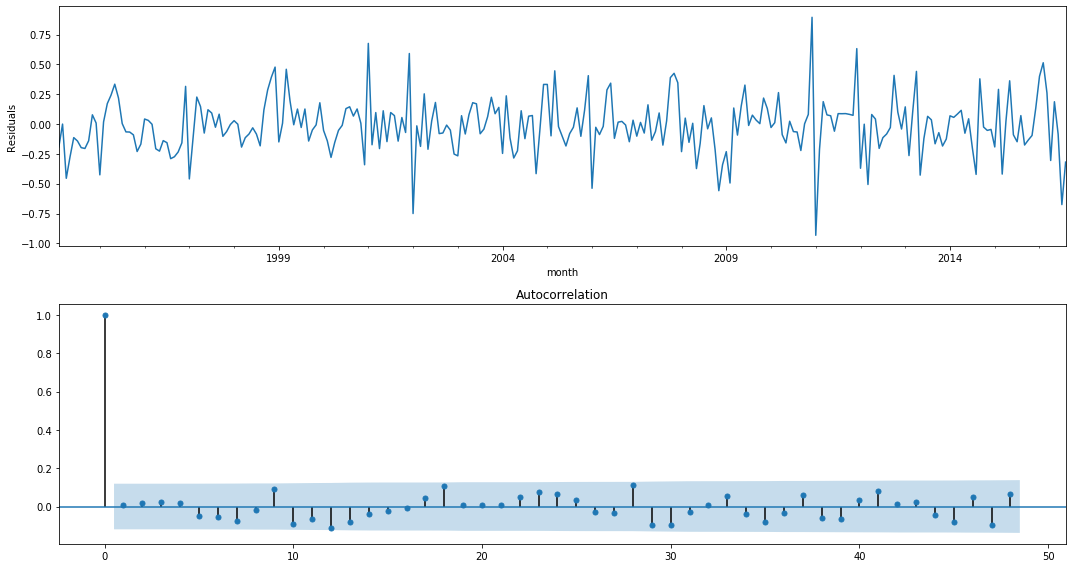

In [135]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

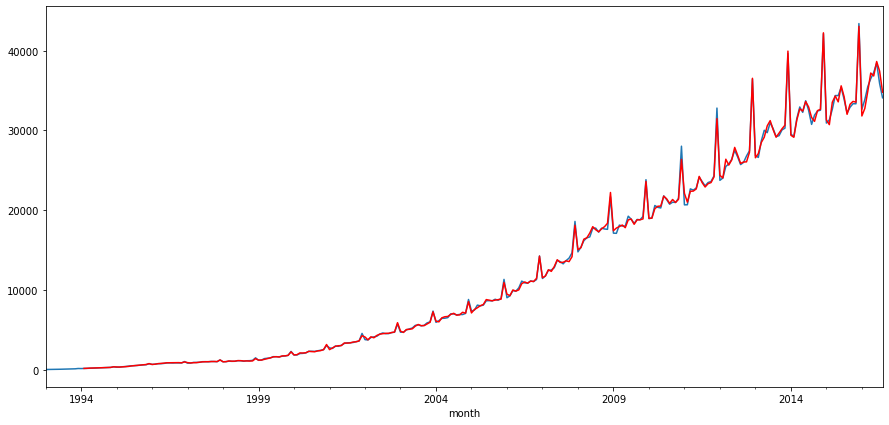

In [136]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
wage['wage'].plot()
wage['model'][13:].plot(color='r')
pylab.show()

Модель довольно хорошо описывает данные.

## Прогнозирование с помощью финальной модели

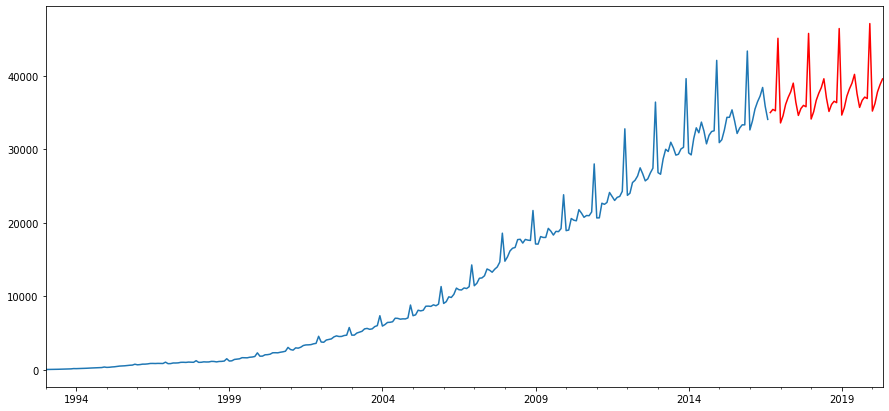

In [138]:
wage_future = wage[['wage']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,45)]
future = pd.DataFrame(index=date_list, columns= wage_future.columns)
wage_future = pd.concat([wage_future, future])
wage_future['forecast'] = invboxcox(best_model.predict(start=284, end=329), lmbda)

plt.figure(figsize=(15,7))
wage_future['wage'].plot()
wage_future['forecast'].plot(color='r')
pylab.show()

P.S.: Сравнил бы с реальными данными, но ссылка в задании битая.😟